In [71]:
import os
os.chdir(r'C:\Users\Dinesh\Documents\Project-4-Workbook-Bundle\Project 4 Workbook Bundle\project_files')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [3]:
df = pd.read_csv('int_online_tx.csv')

In [4]:
df.shape

(35116, 8)

In [5]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/10 8:45,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/10 8:45,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/10 8:45,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,12/1/10 8:45,0.65,12583.0,France
5,536370,10002,INFLATABLE POLITICAL GLOBE,48,12/1/10 8:45,0.85,12583.0,France
6,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,24,12/1/10 8:45,1.25,12583.0,France
7,536370,21035,SET/2 RED RETROSPOT TEA TOWELS,18,12/1/10 8:45,2.95,12583.0,France
8,536370,22326,ROUND SNACK BOXES SET OF4 WOODLAND,24,12/1/10 8:45,2.95,12583.0,France
9,536370,22629,SPACEBOY LUNCH BOX,24,12/1/10 8:45,1.95,12583.0,France


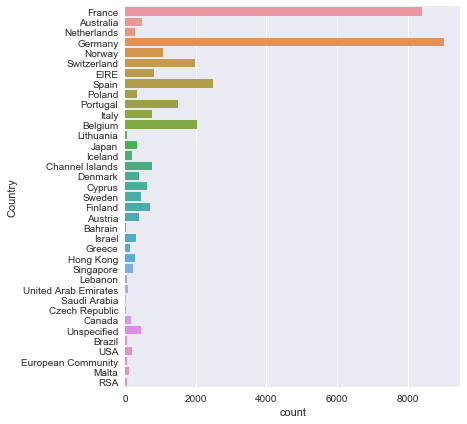

In [6]:
# Make figsize 6x7
plt.figure(figsize=(6,7))

# Bar plot by country
sns.countplot(y='Country', data=df)

In [7]:
df.isnull().sum()

InvoiceNo         0
StockCode         0
Description       0
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID     1418
Country           0
dtype: int64

In [8]:
# Only keep transactions with CustomerID's
df = df[df.CustomerID.notnull()]

In [9]:
# Convert customer ID's into integers
df['CustomerID'] = df.CustomerID.astype(int)

# Display first 5 CustomerID's in the transaction dataset
df.CustomerID.head()

0    12583
1    12583
2    12583
3    12583
4    12583
Name: CustomerID, dtype: int32

In [10]:
# Create 'Sales' interaction feature
df['Sales'] = df.Quantity * df.UnitPrice

# Display first 5 Sales values in the transaction dataset
df.Sales.head()

0    90.0
1    90.0
2    45.0
3    10.2
4    15.6
Name: Sales, dtype: float64

In [11]:
# Save cleaned transaction-level data
df.to_csv('cleaned_transactions.csv', index=None)

In [12]:
# Only keep transactions with CustomerID's
df = df[df.CustomerID.notnull()]

In [13]:
# Convert customer ID's into integers
df['CustomerID'] = df.CustomerID.astype(int)

# Display first 5 CustomerID's in the transaction dataset
df.CustomerID.head()

0    12583
1    12583
2    12583
3    12583
4    12583
Name: CustomerID, dtype: int32

In [14]:
# Create 'Sales' interaction feature
df['Sales'] = df.Quantity * df.UnitPrice

# Display first 5 Sales values in the transaction dataset
df.Sales.head()

0    90.0
1    90.0
2    45.0
3    10.2
4    15.6
Name: Sales, dtype: float64

In [15]:
# Save cleaned transaction-level data
df.to_csv('cleaned_transactions.csv', index=None)

Customer-Level Feature engineering

In [17]:
# Aggegrate invoice data
invoice_data = df.groupby('CustomerID').InvoiceNo.agg({ 'total_transactions' : 'nunique' })

invoice_data.head()

,total_transactions
CustomerID,
12347,7
12348,4
12349,1
12350,1
12352,8


In [18]:
# Aggregate product data
product_data = df.groupby('CustomerID').StockCode.agg( { 'total_products' : 'count', 
                                                     'total_unique_products' : 'nunique' } )
product_data.head()

,total_products,total_unique_products
CustomerID,,
12347,182,103
12348,31,22
12349,73,73
12350,17,17
12352,85,59


In [19]:
# Roll up sales data
sales_data = df.groupby('CustomerID').Sales.agg( { 'total_sales' : 'sum', 
                                                  'avg_product_value' : 'mean' } )
sales_data.head()

,avg_product_value,total_sales
CustomerID,,
12347,23.681319,4310.00
12348,57.975484,1797.24
12349,24.076027,1757.55
12350,19.670588,334.40
12352,29.482824,2506.04


Unable roll up to customer-level directly... therefore creating intermediary levels first.

In [20]:
# Aggregate cart-level data (i.e. invoice-level)
cart_data = df.groupby(['CustomerID' , 'InvoiceNo']).Sales.agg( { 'cart_value' : 'sum' })

# Reset index
cart_data.reset_index(inplace=True)
cart_data.head()

,CustomerID,InvoiceNo,cart_value
0,12347,537626,711.79
1,12347,542237,475.39
2,12347,549222,636.25
3,12347,556201,382.52
4,12347,562032,584.91


In [21]:
# Aggregate cart data (at customer-level)
agg_cart_data = cart_data.groupby('CustomerID').cart_value.agg( { 'avg_cart_value' : 'mean', 
                                                                 'min_cart_value' : 'min',
                                                                 'max_cart_value' : 'max'})
agg_cart_data.head()

,min_cart_value,max_cart_value,avg_cart_value
CustomerID,,,
12347,224.82,1294.32,615.714286
12348,227.44,892.80,449.310000
12349,1757.55,1757.55,1757.550000
12350,334.40,334.40,334.400000
12352,120.33,840.30,313.255000


Joining with the ABT

In [22]:
# Join together customer-level ABT
customer_df = invoice_data.join([product_data, sales_data, agg_cart_data])
customer_df.head()

,total_transactions,total_products,total_unique_products,avg_product_value,total_sales,min_cart_value,max_cart_value,avg_cart_value
CustomerID,,,,,,,,
12347,7,182,103,23.681319,4310.00,224.82,1294.32,615.714286
12348,4,31,22,57.975484,1797.24,227.44,892.80,449.310000
12349,1,73,73,24.076027,1757.55,1757.55,1757.55,1757.550000
12350,1,17,17,19.670588,334.40,334.40,334.40,334.400000
12352,8,85,59,29.482824,2506.04,120.33,840.30,313.255000


In [23]:
# Save analytical base table
customer_df.to_csv('analytical_base_table.csv')

HANDLING THE CURSE OF DIMENSIONALITY

In [24]:
df[['StockCode', 'Description']].head(10)

,StockCode,Description
0,22728,ALARM CLOCK BAKELIKE PINK
1,22727,ALARM CLOCK BAKELIKE RED
2,22726,ALARM CLOCK BAKELIKE GREEN
3,21724,PANDA AND BUNNIES STICKER SHEET
4,21883,STARS GIFT TAPE
5,10002,INFLATABLE POLITICAL GLOBE
6,21791,VINTAGE HEADS AND TAILS CARD GAME
7,21035,SET/2 RED RETROSPOT TEA TOWELS
8,22326,ROUND SNACK BOXES SET OF4 WOODLAND
9,22629,SPACEBOY LUNCH BOX


In [26]:
# Number of unique items
len(df.StockCode.unique())
#Since there are 2574 unique products, this would lead to curse of dimensionality

2574

In [27]:
# Get item_dummies
item_dummies = pd.get_dummies( df.StockCode )

item_dummies['CustomerID'] = df.CustomerID

item_dummies.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,...,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST,CustomerID
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12583
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12583
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12583
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12583
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12583


rolling up item dummies data into customer-level item data

In [28]:
# Create item_data by aggregating at customer level
item_data = item_dummies.groupby('CustomerID').sum()

item_data.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,...,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
12349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12352,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,5


In [31]:
# Total times each item was purchased. This is to check whether the data is sparse or voluminous
item_data.sum()

#they are pretty sparse

10002        12
10120         1
10125        13
10133         5
10135         4
11001         8
15034         5
15036        19
15039         3
15044A        6
15044B        3
15044C        2
15044D        4
15056BL      50
15056N       35
15056P       24
15058A        9
15058B        8
15058C        4
15060B       12
16008        11
16011         3
16012         4
16014        10
16016        16
16045         8
16048         8
16054         2
16156L        6
16156S       12
           ... 
90098         1
90099         2
90108         1
90114         1
90120B        1
90145         2
90160A        1
90160B        1
90160C        1
90160D        1
90161B        1
90161C        1
90161D        1
90162A        1
90162B        1
90164A        1
90170         1
90173         1
90184B        1
90184C        1
90192         1
90201A        1
90201B        3
90201C        2
90201D        1
90202D        1
90204         1
C2            6
M            34
POST       1055
dtype: int64

In [30]:
# Save item_data.csv
item_data.to_csv('item_data.csv')

# Dimensionality reduction - Method 1: Thresholding

In [33]:
#1. Trying the thresholding method

item_data.sum().sort_values().tail(20)

22961      114
22630      115
22139      117
21080      122
85099B     123
20726      123
20719      128
20750      132
23084      140
20725      141
21212      143
22551      158
22629      160
22328      166
21731      169
22556      179
22554      197
22423      222
22326      271
POST      1055
dtype: int64

In [34]:
# Get list of StockCodes for the 20 most popular items
top_20_items = item_data.sum().sort_values().tail(20).index

top_20_items

Index([u'22961', u'22630', u'22139', u'21080', u'85099B', u'20726', u'20719',
       u'20750', u'23084', u'20725', u'21212', u'22551', u'22629', u'22328',
       u'21731', u'22556', u'22554', u'22423', u'22326', u'POST'],
      dtype='object')

In [35]:
# Keep only features for top 20 items
top_20_item_data = item_data[top_20_items]

top_20_item_data.shape

(414, 20)

In [36]:
top_20_item_data.head()

,22961,22630,22139,21080,85099B,20726,20719,20750,23084,20725,21212,22551,22629,22328,21731,22556,22554,22423,22326,POST
CustomerID,,,,,,,,,,,,,,,,,,,,
12347,0,0,0,0,0,0,4,0,3,0,0,0,0,0,5,0,0,4,0,0
12348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
12350,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
12352,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,5


In [37]:
# Save threshold_item_data.csv
top_20_item_data.to_csv('threshold_item_data.csv')

#Keeping this aside for now

# Dimensionality reduction - PCA

PCA seeks to create new features by finding linear combinations of your original ones. These new features, called principal components, are meant to maximize the "explained variance,"

In [41]:
item_data = pd.read_csv('item_data.csv', index_col=0)
item_data.shape

(414, 2574)

In [43]:
#standard scaler
scaler = StandardScaler()
item_data_scaled = scaler.fit_transform(item_data)
item_data_scaled[:5]

array([[-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.68068072],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183,  0.38776219],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.41356999],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.41356999],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
         5.53128397,  0.65487292]])

In [44]:
# Initialize and fit a PCA transformation
pca = PCA()
pca.fit(item_data_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [45]:
# Generate new features
PC_items = pca.transform(item_data_scaled)
PC_items[:5]

array([[  5.87614052e+00,   4.82891689e+00,  -4.95545069e-01, ...,
         -6.62646278e-04,  -4.43629806e-05,   3.48852891e-15],
       [ -4.21983747e+00,   1.22621722e+00,  -1.88191211e+00, ...,
         -2.11471782e-04,  -2.69154340e-04,   4.71237632e-15],
       [ -1.26084676e+00,   2.38766371e+00,  -7.31483440e-02, ...,
          2.57750179e-04,  -2.05682324e-04,   3.40179274e-15],
       [ -4.92931983e+00,  -7.14858724e-01,  -1.58093026e+00, ...,
         -1.98603886e-03,   9.92316312e-05,   4.63518113e-15],
       [ -2.05311348e+00,   2.11095022e+00,   1.84807021e-01, ...,
         -3.43415269e-04,  -1.32981672e-04,   1.01585407e-14]])

- This will tell us the total amount of variance we'd capture if we kept up to the n-th component.
- First, we'll use np.cumsum() to calculate the cumulative explained variance.
- Then, we'll plot it so we can see how many PC features we'd need to keep in order to capture most of the original variance.

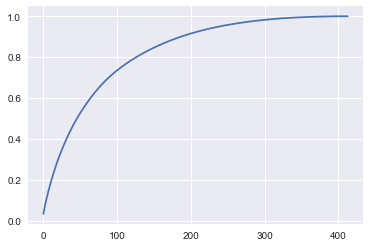

In [47]:
# Cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)

In [49]:
# How much variance we'd capture with the first 125 components
cumulative_explained_variance[124]

0.7955069032205403

Initialize and fit another PCA transformation.

- This time, only keep 125 components.
- Generate the principal component features from the fitted instance and name the new matrix PC_items.
- Then, display the shape of PC_items to confirm it only has 125 features.

In [51]:
# Initialize PCA transformation, only keeping 125 components
pca = PCA(n_components=125)
PC_items = pca.fit_transform(item_data_scaled)

PC_items.shape

(414L, 125L)

In [52]:
# Put PC_items into a dataframe
items_pca = pd.DataFrame(PC_items)

# Name the columns
items_pca.columns = ['PC{}'.format(i + 1) for i in range(PC_items.shape[1])]

# Update its index
items_pca.index = item_data.index

items_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,5.876139,4.828886,-0.495529,3.093840,-0.633752,-11.534071,2.162038,7.116911,5.336128,4.424502,...,-0.047010,-0.815602,0.059873,-0.190315,-0.312286,-0.328450,0.161059,-0.063383,0.408697,-0.380635
12348,-4.219837,1.226238,-1.882007,-0.174236,0.818137,1.160896,-0.871785,-0.846520,0.460209,0.853936,...,2.401278,-0.328651,-0.558526,0.519659,1.204925,-2.344595,0.339885,-0.660368,-0.102124,-0.870653
12349,-1.260838,2.387813,-0.073151,-1.119044,-0.033914,-3.715613,-0.343747,-0.148459,-0.789904,-0.377912,...,-1.488800,-1.183802,3.743445,-0.520694,-1.993631,-4.084283,2.602617,2.003814,0.951226,-2.896586
12350,-4.929321,-0.714817,-1.580796,-0.469845,-0.116234,0.647530,0.112631,-1.336217,1.547050,-1.190127,...,1.222980,0.783704,-0.524176,1.676935,-0.786149,0.535791,1.939223,0.957009,1.187704,0.555932
12352,-2.053106,2.110924,0.184844,0.128239,0.088049,-1.943600,2.383734,0.898857,-0.671702,0.081017,...,8.325876,6.939448,-2.169234,-7.397983,-4.477748,4.087723,-4.190404,-5.395744,-2.337164,-2.317003


In [53]:
# Save pca_item_data.csv
items_pca.to_csv('pca_item_data.csv')

# CLUSTER ANALYSIS

Applying cluster analysis on 3 potential feature sets
- Only purchase pattern features ("Base DF")
- Purchase pattern features + item features chosen by thresholding ("Threshold DF")
- Purchase pattern features + principal components from items ("PCA DF")

In [56]:
base_df = pd.read_csv('analytical_base_table.csv', index_col=0)

threshold_item_data = pd.read_csv('threshold_item_data.csv', index_col=0)

pca_item_data = pd.read_csv('pca_item_data.csv', index_col=0)

In [57]:
# Join base_df with threshold_item_data
threshold_df = base_df.join(threshold_item_data)
threshold_df.head()

,total_transactions,total_products,total_unique_products,avg_product_value,total_sales,min_cart_value,max_cart_value,avg_cart_value,22961,22630,...,21212,22551,22629,22328,21731,22556,22554,22423,22326,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,23.681319,4310.00,224.82,1294.32,615.714286,0,0,...,0,0,0,0,5,0,0,4,0,0
12348,4,31,22,57.975484,1797.24,227.44,892.80,449.310000,0,0,...,0,0,0,0,0,0,0,0,0,4
12349,1,73,73,24.076027,1757.55,1757.55,1757.55,1757.550000,0,0,...,0,0,0,0,0,1,1,1,1,1
12350,1,17,17,19.670588,334.40,334.40,334.40,334.400000,0,0,...,0,1,0,0,0,0,0,0,0,1
12352,8,85,59,29.482824,2506.04,120.33,840.30,313.255000,0,1,...,0,0,0,0,1,0,0,2,0,5


In [58]:
# Join base_df with pca_item_data
pca_df = base_df.join(pca_item_data)
pca_df.head()

,total_transactions,total_products,total_unique_products,avg_product_value,total_sales,min_cart_value,max_cart_value,avg_cart_value,PC1,PC2,...,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,23.681319,4310.00,224.82,1294.32,615.714286,5.876139,4.828886,...,-0.047010,-0.815602,0.059873,-0.190315,-0.312286,-0.328450,0.161059,-0.063383,0.408697,-0.380635
12348,4,31,22,57.975484,1797.24,227.44,892.80,449.310000,-4.219837,1.226238,...,2.401278,-0.328651,-0.558526,0.519659,1.204925,-2.344595,0.339885,-0.660368,-0.102124,-0.870653
12349,1,73,73,24.076027,1757.55,1757.55,1757.55,1757.550000,-1.260838,2.387813,...,-1.488800,-1.183802,3.743445,-0.520694,-1.993631,-4.084283,2.602617,2.003814,0.951226,-2.896586
12350,1,17,17,19.670588,334.40,334.40,334.40,334.400000,-4.929321,-0.714817,...,1.222980,0.783704,-0.524176,1.676935,-0.786149,0.535791,1.939223,0.957009,1.187704,0.555932
12352,8,85,59,29.482824,2506.04,120.33,840.30,313.255000,-2.053106,2.110924,...,8.325876,6.939448,-2.169234,-7.397983,-4.477748,4.087723,-4.190404,-5.395744,-2.337164,-2.317003


# K - Means model pipeline - base data

In [59]:
k_means = make_pipeline(StandardScaler(), KMeans(n_clusters=3, random_state=123))

In [60]:
k_means.fit(base_df)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=123, tol=0.0001, verbose=0))])

In [61]:
# Save clusters to base_df
base_df['cluster'] = k_means.predict(base_df)
base_df.head()

,total_transactions,total_products,total_unique_products,avg_product_value,total_sales,min_cart_value,max_cart_value,avg_cart_value,cluster
CustomerID,,,,,,,,,
12347,7,182,103,23.681319,4310.00,224.82,1294.32,615.714286,1
12348,4,31,22,57.975484,1797.24,227.44,892.80,449.310000,0
12349,1,73,73,24.076027,1757.55,1757.55,1757.55,1757.550000,0
12350,1,17,17,19.670588,334.40,334.40,334.40,334.400000,0
12352,8,85,59,29.482824,2506.04,120.33,840.30,313.255000,0


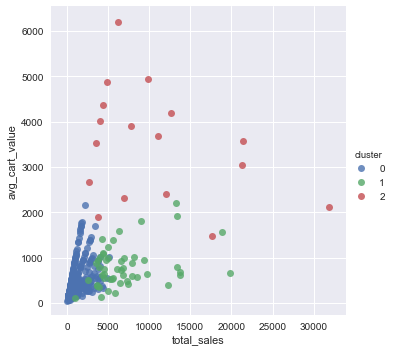

In [62]:
# Scatterplot, colored by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=base_df, fit_reg=False)

# Kmeans with thresholds data

In [63]:
k_means = make_pipeline(StandardScaler(), KMeans(n_clusters=3, random_state=123))
k_means.fit(threshold_df)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=123, tol=0.0001, verbose=0))])

In [64]:
# Save clusters to threshold_df
threshold_df['cluster'] = k_means.predict(threshold_df)
threshold_df.head()

,total_transactions,total_products,total_unique_products,avg_product_value,total_sales,min_cart_value,max_cart_value,avg_cart_value,22961,22630,...,22551,22629,22328,21731,22556,22554,22423,22326,POST,cluster
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,23.681319,4310.00,224.82,1294.32,615.714286,0,0,...,0,0,0,5,0,0,4,0,0,0
12348,4,31,22,57.975484,1797.24,227.44,892.80,449.310000,0,0,...,0,0,0,0,0,0,0,0,4,2
12349,1,73,73,24.076027,1757.55,1757.55,1757.55,1757.550000,0,0,...,0,0,0,0,1,1,1,1,1,2
12350,1,17,17,19.670588,334.40,334.40,334.40,334.400000,0,0,...,1,0,0,0,0,0,0,0,1,2
12352,8,85,59,29.482824,2506.04,120.33,840.30,313.255000,0,1,...,0,0,0,1,0,0,2,0,5,2


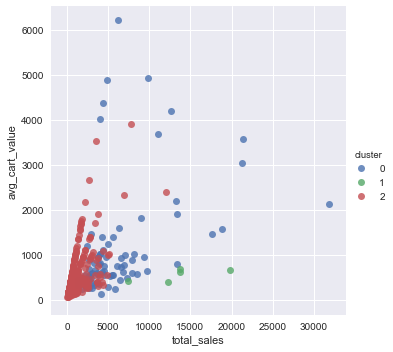

In [65]:
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=threshold_df, fit_reg=False)

# Kmeans with PCA data

In [67]:
# K-Means model pipeline
k_means = make_pipeline(StandardScaler(), KMeans(n_clusters=3, random_state=123))
k_means.fit(pca_df)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=123, tol=0.0001, verbose=0))])

In [68]:
# Save clusters to pca_df
pca_df['cluster'] = k_means.predict(pca_df)
pca_df.head()

,total_transactions,total_products,total_unique_products,avg_product_value,total_sales,min_cart_value,max_cart_value,avg_cart_value,PC1,PC2,...,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125,cluster
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,23.681319,4310.00,224.82,1294.32,615.714286,5.876139,4.828886,...,-0.815602,0.059873,-0.190315,-0.312286,-0.328450,0.161059,-0.063383,0.408697,-0.380635,0
12348,4,31,22,57.975484,1797.24,227.44,892.80,449.310000,-4.219837,1.226238,...,-0.328651,-0.558526,0.519659,1.204925,-2.344595,0.339885,-0.660368,-0.102124,-0.870653,2
12349,1,73,73,24.076027,1757.55,1757.55,1757.55,1757.550000,-1.260838,2.387813,...,-1.183802,3.743445,-0.520694,-1.993631,-4.084283,2.602617,2.003814,0.951226,-2.896586,2
12350,1,17,17,19.670588,334.40,334.40,334.40,334.400000,-4.929321,-0.714817,...,0.783704,-0.524176,1.676935,-0.786149,0.535791,1.939223,0.957009,1.187704,0.555932,2
12352,8,85,59,29.482824,2506.04,120.33,840.30,313.255000,-2.053106,2.110924,...,6.939448,-2.169234,-7.397983,-4.477748,4.087723,-4.190404,-5.395744,-2.337164,-2.317003,2


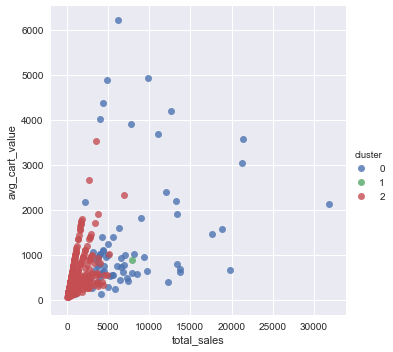

In [69]:
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=pca_df, fit_reg=False)

# MODEL COMPARISON

In [70]:
# Check all indices are identical
print( all( base_df.index == threshold_df.index ) )
print( all( base_df.index == pca_df.index) )

True
True


In [72]:
# Similary between base_df.cluster and threshold_df.cluster
adjusted_rand_score(base_df.cluster, threshold_df.cluster)

0.60213549517823428

In [73]:
# Similary between base_df.cluster and pca_df.cluster
adjusted_rand_score(base_df.cluster, pca_df.cluster)

0.79505810294919665